
# HW1 — Neural ODE on the Lorenz Attractor

实现用 **Neural ODE**（可微 RK4）拟合 **Lorenz 吸引子**，并与高精度数值解对比。


In [8]:

# === Imports ===
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')


## 1. Ground Truth via Fine RK4


In [9]:

# True Lorenz dynamics (NumPy)
def lorenz_true(y, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y_, z = y[..., 0], y[..., 1], y[..., 2]
    dx = sigma * (y_ - x)
    dy = x * (rho - z) - y_
    dz = x * y_ - beta * z
    return np.stack([dx, dy, dz], axis=-1)

# Fine-step RK4 in NumPy
def rk4_numpy(f, y0, t, **fkwargs):
    y = np.zeros((len(t),) + y0.shape, dtype=np.float64)
    y[0] = y0
    for i in range(len(t) - 1):
        h = t[i+1] - t[i]
        yi = y[i]
        k1 = f(yi, **fkwargs)
        k2 = f(yi + 0.5*h*k1, **fkwargs)
        k3 = f(yi + 0.5*h*k2, **fkwargs)
        k4 = f(yi + h*k3, **fkwargs)
        y[i+1] = yi + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return y

# Time and IC
t0, t1 = 0.0, 2.0
dt_truth = 1e-3
t_truth = np.arange(t0, t1 + dt_truth, dt_truth)
y0 = np.array([1.0, 1.0, 1.0], dtype=np.float64)

# Ground truth
y_truth = rk4_numpy(lorenz_true, y0=y0, t=t_truth)

y_truth.shape, t_truth.shape, y_truth[:3]


((2001, 3),
 (2001,),
 array([[1.        , 1.        , 1.        ],
        [1.00012953, 1.025989  , 0.99834858],
        [1.00051627, 1.05196063, 0.99672778]]))

In [ ]:

dt_train = 0.02
t_train = np.arange(t0, t1 + dt_train, dt_train)

stride = int(round(dt_train / dt_truth))
assert abs(stride * dt_truth - dt_train) < 1e-8
y_train_target = y_truth[::stride]
t_train = t_truth[::stride]

y_train_target.shape, t_train.shape


((101, 3), (101,))


## 2. Neural ODE with Differentiable RK4


In [ ]:

class MLPDynamics(nn.Module):
    def __init__(self, dim=3, hidden=64, act=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            act(),
            nn.Linear(hidden, hidden),
            act(),
            nn.Linear(hidden, dim),
        )

    def forward(self, t, y):
        # t is unused but included for API compatibility
        return self.net(y)

def rk4_torch(f, y0, t):
    # y0: (D,) or (B, D); t: (T,)
    if y0.dim() == 1:
        single = True
        yi = y0.unsqueeze(0)        # (1, D)
    else:
        single = False
        yi = y0                      # (B, D)

    traj = [yi]
    T = t.shape[0]

    for i in range(T - 1):
        h = (t[i+1] - t[i]).item()
        ti = t[i].item()
        k1 = f(ti,     yi)
        k2 = f(ti+h/2, yi + h*k1/2)
        k3 = f(ti+h/2, yi + h*k2/2)
        k4 = f(ti+h,   yi + h*k3)
        yi = yi + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        traj.append(yi)

    traj = torch.stack(traj, dim=0)  # (T, 1, D) 或 (T, B, D)
    if single:
        traj = traj.squeeze(1)       # (T, D)
    return traj




## 3. Training


In [12]:

# Prepare tensors
y0_t = torch.tensor(y0, dtype=torch.float32, device=device)
t_train_t = torch.tensor(t_train, dtype=torch.float32, device=device)
y_target_t = torch.tensor(y_train_target, dtype=torch.float32, device=device)

model = MLPDynamics(dim=3, hidden=128, act=nn.Tanh).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10000

def rollout(model, y0_t, t_t):
    return rk4_torch(lambda tt, yy: model(tt, yy), y0_t, t_t)

loss_history = []
for ep in range(1, epochs+1):
    optimizer.zero_grad()
    y_pred = rollout(model, y0_t, t_train_t)  # (T, 3)
    loss = ((y_pred - y_target_t)**2).mean()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if ep % 100 == 0:
        print(f"Epoch {ep:4d} | MSE: {loss.item():.6f}")


Epoch  100 | MSE: 94.672379
Epoch  200 | MSE: 88.782555
Epoch  300 | MSE: 88.702583
Epoch  400 | MSE: 86.612885
Epoch  500 | MSE: 75.521141
Epoch  600 | MSE: 64.131577
Epoch  700 | MSE: 58.013409
Epoch  800 | MSE: 53.839737
Epoch  900 | MSE: 50.028530
Epoch 1000 | MSE: 46.523060
Epoch 1100 | MSE: 43.347328
Epoch 1200 | MSE: 40.531132
Epoch 1300 | MSE: 38.090893
Epoch 1400 | MSE: 35.932678
Epoch 1500 | MSE: 33.865978
Epoch 1600 | MSE: 32.253170
Epoch 1700 | MSE: 30.873209
Epoch 1800 | MSE: 29.551962
Epoch 1900 | MSE: 28.366505
Epoch 2000 | MSE: 27.363775
Epoch 2100 | MSE: 26.503307
Epoch 2200 | MSE: 25.536436
Epoch 2300 | MSE: 24.318495
Epoch 2400 | MSE: 23.453453
Epoch 2500 | MSE: 22.756794
Epoch 2600 | MSE: 21.987574
Epoch 2700 | MSE: 21.401094
Epoch 2800 | MSE: 20.828279
Epoch 2900 | MSE: 20.146179
Epoch 3000 | MSE: 19.581095
Epoch 3100 | MSE: 19.193657
Epoch 3200 | MSE: 18.887571
Epoch 3300 | MSE: 18.481184
Epoch 3400 | MSE: 18.175098
Epoch 3500 | MSE: 17.881350
Epoch 3600 | MSE: 17


## 4. Evaluation & Plots


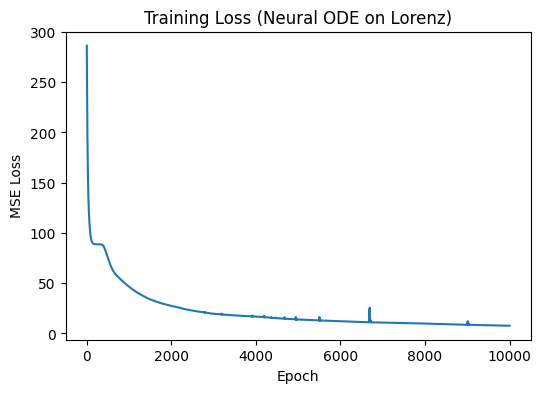

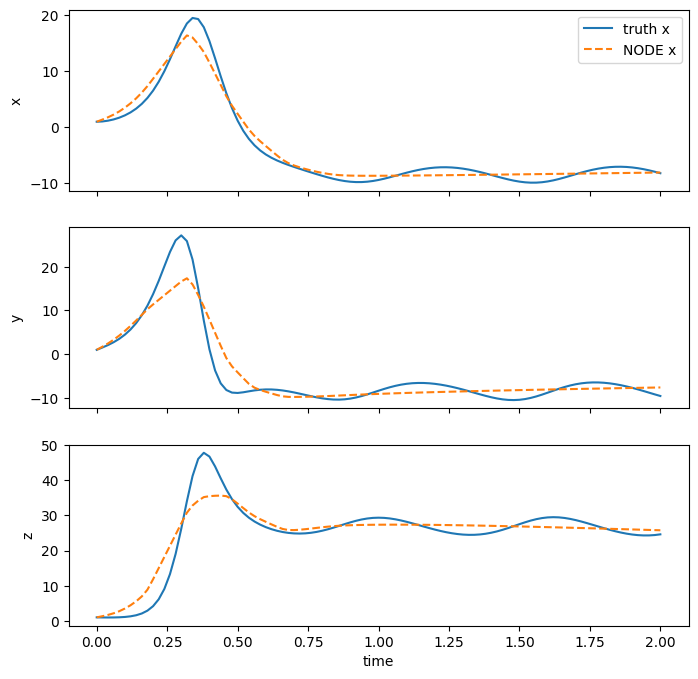

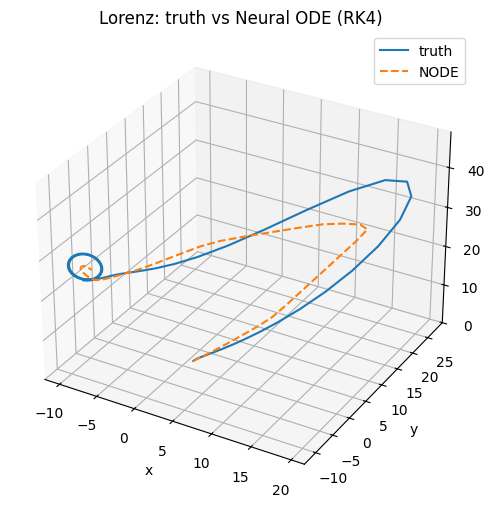

Overall MSE on training grid: 7.665236
MSE on first 3 seconds:       7.665236


In [13]:

with torch.no_grad():
    y_pred_t = rollout(model, y0_t, t_train_t).cpu().numpy()

# 1) Training loss
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss (Neural ODE on Lorenz)")
plt.show()

# 2) Component-wise comparison
fig, axes = plt.subplots(3, 1, figsize=(8,8), sharex=True)
labels = ['x', 'y', 'z']
for i, ax in enumerate(axes):
    ax.plot(t_train, y_train_target[:, i], label=f"truth {labels[i]}")
    ax.plot(t_train, y_pred_t[:, i], linestyle='--', label=f"NODE {labels[i]}")
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("time")
axes[0].legend()
plt.show()

# 3) 3D trajectory comparison
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_train_target[:,0], y_train_target[:,1], y_train_target[:,2], label="truth")
ax.plot(y_pred_t[:,0], y_pred_t[:,1], y_pred_t[:,2], linestyle='--', label="NODE")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title("Lorenz: truth vs Neural ODE (RK4)")
ax.legend()
plt.show()

# Metrics
def mse(a, b):
    return float(np.mean((a - b)**2))

overall_mse = mse(y_pred_t, y_train_target)
first3_mse = mse(y_pred_t[:int(3.0/dt_train)+1], y_train_target[:int(3.0/dt_train)+1])
print(f"Overall MSE on training grid: {overall_mse:.6f}")
print(f"MSE on first 3 seconds:       {first3_mse:.6f}")
